In [8]:
import cv2
import numpy as np

def resize_image_with_padding(image_path, target_size=(224, 224)):
    """
    Resizes an image to a target size using padding.

    Args:
        image_path (str): The path to the image file.
        target_size (tuple): The desired size of the image (width, height).

    Returns:
        numpy.ndarray: The resized image with padding.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    height, width = img.shape[:2]
    target_width, target_height = target_size

    # Resize the image if the target size is smaller than the original size
    if width > target_width or height > target_height:
        img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)
        height, width = img.shape[:2]  # Update height and width after resizing

    # Calculate padding values
    delta_w = target_width - width
    delta_h = target_height - height
    pad_top = delta_h // 2
    pad_bottom = delta_h - pad_top
    pad_left = delta_w // 2
    pad_right = delta_w - pad_left

    # Add padding to the image
    color = [0, 0, 0]  # Black padding
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=color)

    return padded_img

# Example usage:
image_path = "C:\\Users\\sheno\\OneDrive\\CODCSD201F-006-SetupFile\\Desktop\\research\\dataset\\OCT2017_CLEAN\\test\\DME\\DME-30521-5.png"
resized_image = resize_image_with_padding(image_path)
#"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\research\dataset\OCT2017\train\CNV\CNV-28682-8.jpeg"
#"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\research\dataset\OCT2017_CLEAN\test\DME\DME-30521-5.png"

# Optionally, save the resized image
cv2.imwrite("resized_image.jpg", resized_image)

print(f"Resized image shape: {resized_image.shape}")

Resized image shape: (224, 224, 3)


In [9]:
cv2.imshow("image_path", resized_image)
cv2.imshow("Resized Image", resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
import numpy as np
import cv2

# fill white border area with black (uses existing notebook variables)

# determine source image to modify
if 'modified_image' in globals():
    img = resized_image.copy()
elif 'resized_image' in globals():
    img = resized_image.copy()
else:
    raise RuntimeError("No image variable found to modify (expected 'modified_image' or 'resized_image').")

h, w = img.shape[:2]

# Create a white mask: require all color channels to be near 255 for color images
if img.ndim == 3 and img.shape[2] == 3:
    white_mask = np.all(img >= 250, axis=2)
else:
    # grayscale image
    white_mask = (img >= 250)

# If no white pixels, nothing to do
if not np.any(white_mask):
    modified_image = img
    print("No white pixels found; nothing to fill.")
else:
    # Connected components on the white mask to find regions
    white_u8 = (white_mask.astype('uint8') * 255)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(white_u8, connectivity=8)

    # Find components whose bounding box touches the image border
    border_labels = []
    for lbl in range(1, num_labels):  # skip background label 0
        left = stats[lbl, cv2.CC_STAT_LEFT]
        top = stats[lbl, cv2.CC_STAT_TOP]
        width = stats[lbl, cv2.CC_STAT_WIDTH]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if left == 0 or top == 0 or (left + width) == w or (top + height) == h:
            border_labels.append(lbl)

    if len(border_labels) == 0:
        # fallback: if no connected component bbox touches border, just remove white pixels that are literally on image edges
        full_border_mask = np.zeros_like(white_mask, dtype=bool)
        full_border_mask[0, :] = white_mask[0, :]
        full_border_mask[-1, :] = white_mask[-1, :]
        full_border_mask[:, 0] = full_border_mask[:, 0] | white_mask[:, 0]
        full_border_mask[:, -1] = full_border_mask[:, -1] | white_mask[:, -1]
    else:
        # build mask of all pixels that belong to border-touching components
        full_border_mask = np.isin(labels, border_labels)

    # target: white pixels inside the border area
    target_mask = white_mask & full_border_mask

    # apply: set those pixels to black
    if img.ndim == 3:
        img[target_mask, :] = 0
    else:
        img[target_mask] = 0

    # write back
    modified_image = img
    cv2.imwrite('modified_image_no_white_border.png', modified_image)

    print(f"Filled {int(np.count_nonzero(target_mask))} white-border pixels with black.")

# show result (may not display inline in some notebook setups)
cv2.imshow("border removed Image", modified_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Filled 2396 white-border pixels with black.


#option1

sigma_est=0.0259, used_sigma=0.0500, tv_weight=0.02


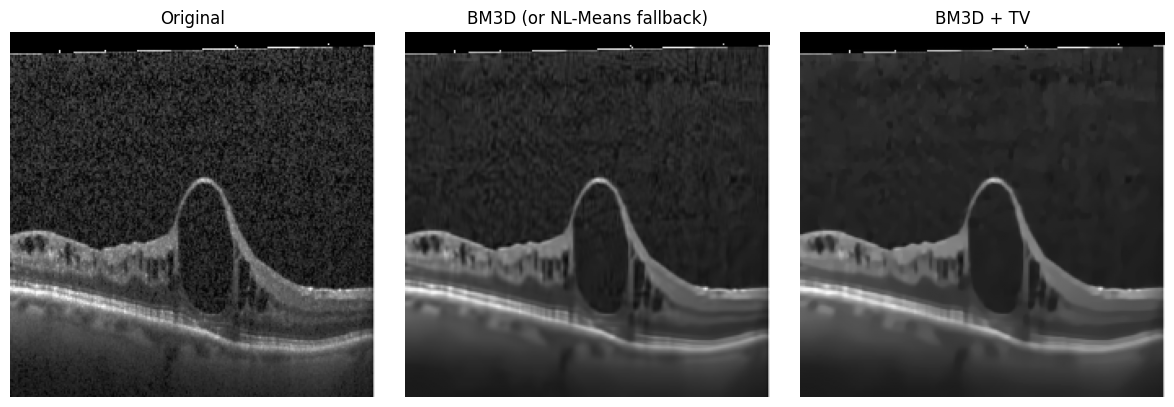

In [32]:
import importlib
from skimage.restoration import denoise_tv_chambolle, denoise_nl_means, estimate_sigma

# Apply BM3D / BM3D-TV speckle reduction (uses existing variables: proc or modified_image)
# Installs bm3d if missing, falls back to skimage methods if necessary.
import matplotlib.pyplot as plt

# pick input (prefer 'proc' if present, else convert modified_image to gray)
if 'proc' in globals():
    src = proc  # already grayscale (224,224)
else:
    # convert modified_image (BGR) to gray
    src = cv2.cvtColor(modified_image, cv2.COLOR_BGR2GRAY)

# normalize to [0,1] float
img = (src.astype('float32') / 255.0).copy()

# try to import bm3d
bm3d = None
try:
    mod = importlib.import_module('bm3d')
    # the common API is bm3d.bm3d(image, sigma_psd)
    bm3d = getattr(mod, 'bm3d', None)
except Exception:
    bm3d = None

# estimate noise (if you know speckle sigma you can override this)
sigma_est = float(estimate_sigma(img, channel_axis=None))
# set a default if estimate is too small
sigma = max(sigma_est, 0.05)

if bm3d is not None:
    try:
        den_bm3d = bm3d(img, sigma_psd=sigma)
    except TypeError:
        # some bm3d variants expect a different param name
        den_bm3d = bm3d(img, sigma)
else:
    # fallback: use Non-local means as a proxy for BM3D
    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 6 pixels search
                    multichannel=False)
    den_bm3d = denoise_nl_means(img, h=1.15 * sigma, fast_mode=True, **patch_kw)

# BM3D-TV: apply a light TV refinement after BM3D result
tv_weight = 0.02  # adjust between 0 (no TV) and ~0.2 (stronger smoothing)
den_bm3d_tv = denoise_tv_chambolle(den_bm3d, weight=tv_weight, channel_axis=None)

# convert results back to uint8 for saving/display
def to_uint8(x):
    x = np.clip(x * 255.0, 0, 255).astype('uint8')
    return x

out_bm3d = to_uint8(den_bm3d)
out_bm3d_tv = to_uint8(den_bm3d_tv)
src_u8 = to_uint8(img)

# show results inline
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original'); plt.axis('off'); plt.imshow(src_u8, cmap='gray')
plt.subplot(1,3,2); plt.title('BM3D (or NL-Means fallback)'); plt.axis('off'); plt.imshow(out_bm3d, cmap='gray')
plt.subplot(1,3,3); plt.title('BM3D + TV'); plt.axis('off'); plt.imshow(out_bm3d_tv, cmap='gray')
plt.tight_layout()

# expose outputs in notebook namespace
bm3d_denoised = out_bm3d
bm3d_tv_denoised = out_bm3d_tv

# optional: save results
cv2.imwrite('denoised_bm3d.png', bm3d_denoised)
cv2.imwrite('denoised_bm3d_tv.png', bm3d_tv_denoised)
print(f"sigma_est={sigma_est:.4f}, used_sigma={sigma:.4f}, tv_weight={tv_weight}")

#option2

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import math

# Self-supervised Noise2Void / PN2V-like training on `modified_image`
# Produces `n2v_denoised` (uint8, 0-255) and saves 'denoised_n2v.png'
import torch.nn as nn
import torch.optim as optim

# use existing notebook variable `modified_image` (BGR uint8)
img_gray = cv2.cvtColor(modified_image, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0

# Dataset: random patches with random blind-spot masks (corrupt inputs at mask locations)
class N2VDataset(Dataset):
    def __init__(self, img, patch_size=64, n_patches=1024, mask_fraction=0.01):
        self.img = img
        self.h, self.w = img.shape
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.mask_fraction = mask_fraction
    def __len__(self):
        return self.n_patches
    def __getitem__(self, idx):
        ps = self.patch_size
        y = random.randint(0, self.h - ps)
        x = random.randint(0, self.w - ps)
        patch = self.img[y:y+ps, x:x+ps].copy()
        # create mask
        n_mask = max(1, int(ps*ps*self.mask_fraction))
        mask = torch.zeros((ps, ps), dtype=torch.bool)
        for _ in range(n_mask):
            ry, rx = random.randrange(ps), random.randrange(ps)
            mask[ry, rx] = True
            # corrupt: replace masked pixel with random neighbor from patch
            ny = min(ps-1, max(0, ry + random.choice([-1,0,1])))
            nx = min(ps-1, max(0, rx + random.choice([-1,0,1])))
            if ny==ry and nx==rx:
                # fallback: set to 0
                patch[ry, rx] = 0.0
            else:
                patch[ry, rx] = patch[ny, nx]
        inp = torch.from_numpy(patch).unsqueeze(0)  # (1,H,W)
        tgt = torch.from_numpy(self.img[y:y+ps, x:x+ps]).unsqueeze(0)
        return inp.float(), tgt.float(), mask

# small conv network (blind-spot achieved by masking during training)
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparams (small for demo)
patch_size = 64
dataset = N2VDataset(img_gray, patch_size=patch_size, n_patches=2048, mask_fraction=0.01)
dloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=0)

model = SmallConvNet().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss(reduction='sum')

# Training loop (brief)
epochs = 6
for ep in range(epochs):
    model.train()
    running_loss = 0.0
    seen_masks = 0
    for inp, tgt, mask in dloader:
        inp = inp.to(device)
        tgt = tgt.to(device)
        mask = mask.to(device)  # bool (B,H,W)
        opt.zero_grad()
        out = model(inp)  # (B,1,H,W)
        # compute loss only on masked pixels
        mask_f = mask.unsqueeze(1).float()  # (B,1,H,W)
        num_mask = mask_f.sum()
        if num_mask.item() == 0:
            continue
        mse = ((out - tgt) ** 2 * mask_f).sum() / num_mask
        mse.backward()
        opt.step()
        running_loss += mse.item()
        seen_masks += 1
    avg_loss = running_loss / max(1, seen_masks)
    print(f"Epoch {ep+1}/{epochs} average masked MSE={avg_loss:.6f}")

# Inference on full image (sliding-window pad to patch_size with reflection)
model.eval()
with torch.no_grad():
    H, W = img_gray.shape
    pad_h = (math.ceil(H / patch_size) * patch_size) - H
    pad_w = (math.ceil(W / patch_size) * patch_size) - W
    img_pad = np.pad(img_gray, ((0,pad_h),(0,pad_w)), mode='reflect')
    out_img = np.zeros_like(img_pad, dtype=np.float32)
    count_img = np.zeros_like(img_pad, dtype=np.float32)
    for y in range(0, img_pad.shape[0], patch_size):
        for x in range(0, img_pad.shape[1], patch_size):
            patch = img_pad[y:y+patch_size, x:x+patch_size]
            inp = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).float().to(device)
            pred = model(inp).squeeze().cpu().numpy()
            out_img[y:y+patch_size, x:x+patch_size] += pred
            count_img[y:y+patch_size, x:x+patch_size] += 1.0
    out_img = out_img[:H, :W] / count_img[:H, :W]
    out_img = np.clip(out_img, 0.0, 1.0)
    n2v_denoised = (out_img * 255.0).astype('uint8')

# save and expose
cv2.imwrite('denoised_n2v.png', n2v_denoised)
print("Saved denoised_n2v.png — variable `n2v_denoised` available in notebook.")

Epoch 1/6 average masked MSE=0.004453
Epoch 2/6 average masked MSE=0.002103
Epoch 3/6 average masked MSE=0.002026
Epoch 4/6 average masked MSE=0.001952
Epoch 5/6 average masked MSE=0.001918
Epoch 6/6 average masked MSE=0.001946
Saved denoised_n2v.png — variable `n2v_denoised` available in notebook.


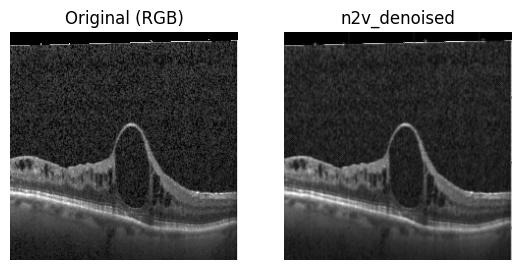

In [35]:
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original (RGB)"); plt.axis('off'); plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2); plt.title("n2v_denoised"); plt.axis('off'); plt.imshow(cv2.cvtColor(n2v_denoised, cv2.COLOR_BGR2RGB))

option 3

In [18]:
import time

# Self2Self (S2S) single-image despeckling for OCT using `modified_image` (expects variables present in notebook)
# Produces: s2s_denoised (uint8) and saves 'denoised_s2s.png'
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# use existing grayscale image if available, else convert modified_image
if 'img_gray' in globals():
    img = img_gray.astype('float32')
else:
    img = cv2.cvtColor(modified_image, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0

H, W = img.shape
device = device if 'device' in globals() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset: single-image patch sampling with random blind-mask (S2S style)
class S2SDataset(torch.utils.data.Dataset):
    def __init__(self, image, patch_size=64, n_patches=4096, mask_fraction=0.05):
        self.img = image
        self.h, self.w = image.shape
        self.ps = patch_size
        self.n_patches = n_patches
        self.mask_frac = mask_fraction
    def __len__(self):
        return self.n_patches
    def __getitem__(self, idx):
        ps = self.ps
        y = random.randint(0, self.h - ps)
        x = random.randint(0, self.w - ps)
        patch = self.img[y:y+ps, x:x+ps].copy()
        # mask: Bernoulli per-pixel, ensure at least one masked pixel
        mask = (np.random.rand(ps, ps) < self.mask_frac)
        if not mask.any():
            ry, rx = random.randrange(ps), random.randrange(ps)
            mask[ry, rx] = True
        # corrupt masked pixels by copying random neighbor within the patch
        corrupted = patch.copy()
        ys, xs = np.where(mask)
        for (ry, rx) in zip(ys, xs):
            ny = min(ps-1, max(0, ry + random.choice([-1,0,1])))
            nx = min(ps-1, max(0, rx + random.choice([-1,0,1])))
            if ny==ry and nx==rx:
                corrupted[ry, rx] = 0.0
            else:
                corrupted[ry, rx] = patch[ny, nx]
        inp = torch.from_numpy(corrupted).unsqueeze(0).float()  # (1,H,W)
        tgt = torch.from_numpy(patch).unsqueeze(0).float()
        mask_t = torch.from_numpy(mask).bool()
        return inp, tgt, mask_t

# Small UNet with dropout to allow stochastic inference
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.1):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.ReLU(inplace=True),
        )
        self.drop = torch.nn.Dropout2d(p_drop)
    def forward(self, x):
        return self.drop(self.block(x))

class UNetSmall(torch.nn.Module):
    def __init__(self, p_drop=0.2):
        super().__init__()
        self.enc1 = ConvBlock(1, 32, p_drop=0.05)
        self.enc2 = ConvBlock(32, 64, p_drop=0.1)
        self.enc3 = ConvBlock(64, 128, p_drop=0.2)
        self.pool = torch.nn.MaxPool2d(2)
        self.up2 = torch.nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64, p_drop=0.1)
        self.up1 = torch.nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32, p_drop=0.05)
        self.outc = torch.nn.Conv2d(32, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.up2(e3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.outc(d1)
        return out

# Hyperparams
patch_size = 64
n_patches = 4096
mask_fraction = 0.05
batch_size = 16
epochs = 60
lr = 1e-3

dataset_s2s = S2SDataset(img, patch_size=patch_size, n_patches=n_patches, mask_fraction=mask_fraction)
dloader = torch.utils.data.DataLoader(dataset_s2s, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)

model_s2s = UNetSmall(p_drop=0.2).to(device)
opt = torch.optim.Adam(model_s2s.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction='sum')

# training
start = time.time()
s2s_running_loss = 0.0
s2s_seen = 0
for ep in range(epochs):
    model_s2s.train()
    ep_loss = 0.0
    seen = 0
    for inp, tgt, mask in dloader:
        inp = inp.to(device)
        tgt = tgt.to(device)
        mask = mask.to(device)  # (B,H,W) bool
        opt.zero_grad()
        out = model_s2s(inp)
        mask_f = mask.unsqueeze(1).float()  # (B,1,H,W)
        num_mask = mask_f.sum()
        if num_mask.item() == 0:
            continue
        mse = ((out - tgt) ** 2 * mask_f).sum() / num_mask
        mse.backward()
        opt.step()
        ep_loss += mse.item()
        seen += 1
    if seen > 0:
        avg = ep_loss / seen
    else:
        avg = 0.0
    s2s_running_loss += ep_loss
    s2s_seen += seen
    # light print per 10 epochs
    if (ep+1) % 10 == 0 or (ep==epochs-1):
        print(f"S2S epoch {ep+1}/{epochs} avg masked MSE={avg:.6f}")
s2s_avg_loss = s2s_running_loss / max(1, s2s_seen)
elapsed = time.time() - start

# Inference: stochastic forward passes (enable dropout by keeping model in train mode) and average
n_samples = 12
model_s2s.train()  # keep dropout active for MC sampling
with torch.no_grad():
    inp_full = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float().to(device)  # (1,1,H,W)
    acc = torch.zeros_like(inp_full)
    for i in range(n_samples):
        pred = model_s2s(inp_full)
        acc += pred
    out_avg = (acc / float(n_samples)).squeeze().cpu().numpy()
    out_avg = np.clip(out_avg, 0.0, 1.0)

s2s_denoised = (out_avg * 255.0).astype('uint8')
cv2.imwrite('denoised_s2s.png', s2s_denoised)
print(f"Saved denoised_s2s.png (H={H},W={W}) epochs={epochs} time={elapsed:.1f}s s2s_avg_loss={s2s_avg_loss:.6f}")

KeyboardInterrupt: 

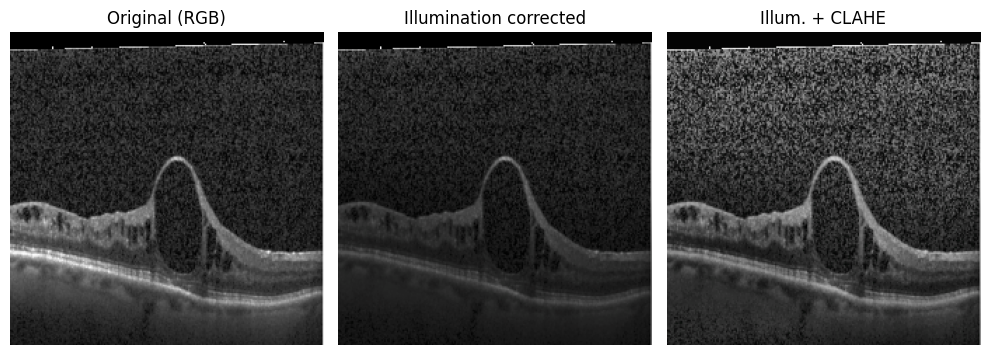

In [34]:
# illumination correction + CLAHE on `modified_image`
if 'modified_image' not in globals():
    raise RuntimeError("Expecting `modified_image` in notebook namespace.")

# convert to LAB and work on L channel
lab = cv2.cvtColor(modified_image, cv2.COLOR_BGR2LAB)
L = lab[:, :, 0].astype('float32')

# estimate smooth background illumination (large gaussian)
bg = cv2.GaussianBlur(L, ksize=(0, 0), sigmaX=30, sigmaY=30)

# avoid division by zero and compute ratio illumination correction
bg += 1e-6
ratio = L / bg

# normalize ratio back to 0-255
ratio_norm = cv2.normalize(ratio, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype('uint8')

# simple corrected image (put normalized ratio into L channel)
lab_corr = lab.copy()
lab_corr[:, :, 0] = ratio_norm
illum_corrected = cv2.cvtColor(lab_corr, cv2.COLOR_LAB2BGR)

# apply CLAHE on the corrected L channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
L_corr = cv2.cvtColor(illum_corrected, cv2.COLOR_BGR2LAB)[:, :, 0]
L_clahe = clahe.apply(L_corr)

lab_clahe = cv2.cvtColor(illum_corrected, cv2.COLOR_BGR2LAB)
lab_clahe[:, :, 0] = L_clahe
clahe_result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# save and expose variables
cv2.imwrite('illum_corrected.png', illum_corrected)
cv2.imwrite('illum_corrected_clahe.png', clahe_result)

# show inline (matplotlib expects RGB)
try:
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original (RGB)"); plt.axis('off'); plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2); plt.title("Illumination corrected"); plt.axis('off'); plt.imshow(cv2.cvtColor(illum_corrected, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,3); plt.title("Illum. + CLAHE"); plt.axis('off'); plt.imshow(cv2.cvtColor(clahe_result, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()
except Exception:
    print("Saved 'illum_corrected.png' and 'illum_corrected_clahe.png'.")